# F1 Project: Beating the Odds

---
# <font color='yellow'>Data Source, Import Packages</font>

## Import package

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, accuracy_score

# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.neural_network import MLPClassifier, MLPRegressor

## Read file

In [2]:
# primary dataset
df_races = pd.read_csv('./data/races.csv')
df_results = pd.read_csv('./data/results copy.csv')
df_qualifying = pd.read_csv('./data/qualifying_update.csv')
df_driver_standings = pd.read_csv('./data/driver_standings.csv')
df_constructor_standings = pd.read_csv('./data/constructor_standings.csv')

In [3]:
# secondary dataset
df_constructor_results = pd.read_csv('./data/constructor_results.csv')
df_pit_stops = pd.read_csv('./data/pit_stops.csv')
df_lap_times = pd.read_csv('./data/lap_times.csv')

In [4]:
# lookup dataset
df_constructors = pd.read_csv('./data/constructors.csv')
df_drivers = pd.read_csv('./data/drivers.csv')
df_status = pd.read_csv('./data/status.csv')
df_circuits = pd.read_csv('./data/circuits.csv')

---
# <font color='yellow'> Wrangling, Cleaning, Exploring</font>

## MERGING

In [5]:
# RACES
# merge, drop
merge_races = pd.merge(df_races, df_circuits, 
                       how='inner', 
                       on=['circuitId'])

races = merge_races.drop(columns = ['name_x', 'time', 'date', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'name_y', 'url_y'])

# sort, reindex, reset index
races.sort_values(['year', 'round'], ascending = True, inplace = True)
races = races.reindex(columns = ['year', 'round', 'circuitRef', 'location', 'country', 'lat', 'lng', 'alt', 'raceId'])
races.reset_index(drop = True, inplace = True)

In [6]:
# RESULTS
# merge, drop
merge_results = pd.merge(df_results, races,
                   how='inner', 
                   on=['raceId'])

drop_results = merge_results.drop(columns = ['positionText', 'position', 'number', 'location',
                                       'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed'])

merge_results2 = pd.merge(drop_results, df_status,
                   how='inner', 
                   on=['statusId'])

merge_results3 = pd.merge(merge_results2, df_constructors[['constructorId', 'constructorRef']],
                   how='inner', 
                   on=['constructorId'])

results = pd.merge(merge_results3, df_drivers[['driverId', 'driverRef','dob','nationality']],
                   how='inner', 
                   on=['driverId'])

# sort, reindex, reset index
results.sort_values(['year', 'round', 'positionOrder'], ascending = True, inplace = True)
results = results.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'driverRef','dob', 'nationality', 
                                     'grid', 'positionOrder', 'points', 'status', 'laps', 'time', 'milliseconds', 'lat', 'lng','alt','country','resultId', 
                                     'raceId', 'circuitId', 'constructorId', 'driverId', 'statusId'])
results.reset_index(drop = True, inplace = True)

In [7]:
# QUALIFYING (partly manipulated in excel)
# merge, drop
merge_qualifying = pd.merge(df_qualifying, 
                            df_drivers[['driverId', 'driverRef']],
                   how='left', 
                   on=['driverId'])

merge_qualifying2 = pd.merge(merge_qualifying, 
                            df_constructors[['constructorId', 'constructorRef']],
                   how='left', 
                   on=['constructorId'])

merge_qualifying3 = pd.merge(merge_qualifying2, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

qualifying = merge_qualifying3.drop(columns = ['qualifyId', 'number', 'q1', 'q2', 'q3'])

# sort, reindex, reset index
qualifying.sort_values(['year', 'round', 'position'], ascending = True, inplace = True)
qualifying = qualifying.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'driverRef','q', 'position', 
                                           'raceId', 'driverId', 'constructorId'])
qualifying.reset_index(drop = True, inplace = True)

In [8]:
# DRIVER STANDINGS
# merge, drop
merge_driver_standings = pd.merge(df_driver_standings, 
                            df_drivers[['driverId', 'driverRef']],
                   how='left', 
                   on=['driverId'])

merge_driver_standings2 = pd.merge(merge_driver_standings, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

merge_driver_standings3 = pd.merge(merge_driver_standings2, 
                            results[['raceId', 'driverId', 'constructorRef']],
                   how='left', 
                   on=['raceId', 'driverId'])

driver_standings = merge_driver_standings3.drop(columns = ['positionText', 'driverStandingsId'])

# sort, reindex, reset index
driver_standings.sort_values(['year', 'round', 'position'], ascending = True, inplace = True)
driver_standings = driver_standings.reindex(columns = ['year', 'round', 'circuitRef', 'driverRef', 'position', 'wins', 'points',  
                                           'raceId', 'driverId'])
driver_standings.reset_index(drop = True, inplace = True)

In [9]:
# CONSTRUCTOR STANDINGS
# merge, drop
merge_constructor_standings = pd.merge(df_constructor_standings, 
                            df_constructors[['constructorId', 'constructorRef']],
                   how='left', 
                   on=['constructorId'])

merge_constructor_standings2 = pd.merge(merge_constructor_standings, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

constructor_standings = merge_constructor_standings2.drop(columns = ['positionText', 'constructorStandingsId'])

# sort, reindex, reset index
constructor_standings.sort_values(['year', 'round', 'position'], ascending = True, inplace = True)
constructor_standings = constructor_standings.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'position', 'wins', 'points',  
                                           'raceId', 'constructorId'])
constructor_standings.reset_index(drop = True, inplace = True)

In [10]:
# PIT STOPS
# merge, drop
merge_pit_stops = pd.merge(df_pit_stops, 
                            df_drivers[['driverId', 'driverRef']],
                   how='left', 
                   on=['driverId'])

merge_pit_stops2 = pd.merge(merge_pit_stops, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

pit_stops = pd.merge(merge_pit_stops2, 
                            results[['raceId', 'driverId', 'constructorRef']],
                   how='left', 
                   on=['raceId', 'driverId'])

pit_stops = pit_stops.drop(columns = ['time'])

# # sort, reindex, reset index
pit_stops.sort_values(['year', 'round'], ascending = True, inplace = True)
pit_stops = pit_stops.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'driverRef', 'stop', 'lap', 'duration', 'milliseconds', 
                                           'raceId', 'driverId'])
pit_stops.reset_index(drop = True, inplace = True)

In [11]:
# CONSTRUCTOR RESULTS
# merge, drop
merge_constructor_results = pd.merge(df_constructor_results, 
                            df_constructors[['constructorId', 'constructorRef']],
                   how='left', 
                   on=['constructorId'])

merge_constructor_results2 = pd.merge(merge_constructor_results, 
                            races[['raceId', 'year', 'round', 'circuitRef']],
                   how='left', 
                   on=['raceId'])

merge_constructor_results2

constructor_results = merge_constructor_results2.drop(columns = ['constructorResultsId'])
constructor_results

# sort, reindex, reset index
constructor_results.sort_values(['year', 'round', 'points'], ascending = True, inplace = True)
constructor_results = constructor_results.reindex(columns = ['year', 'round', 'circuitRef', 'constructorRef', 'points', 'status', 
                                           'raceId', 'constructorId'])
constructor_results.reset_index(drop = True, inplace = True)

## EXPLORING

### races

In [12]:
races.head()
    # when and where the races happened by country and location

,year,round,circuitRef,location,country,lat,lng,alt,raceId
0,1950,1,silverstone,Silverstone,UK,52.0786,-1.01694,153,833
1,1950,2,monaco,Monte-Carlo,Monaco,43.7347,7.42056,7,834
2,1950,3,indianapolis,Indianapolis,USA,39.7950,-86.23470,223,835
3,1950,4,bremgarten,Bern,Switzerland,46.9589,7.40194,551,836
4,1950,5,spa,Spa,Belgium,50.4372,5.97139,401,837


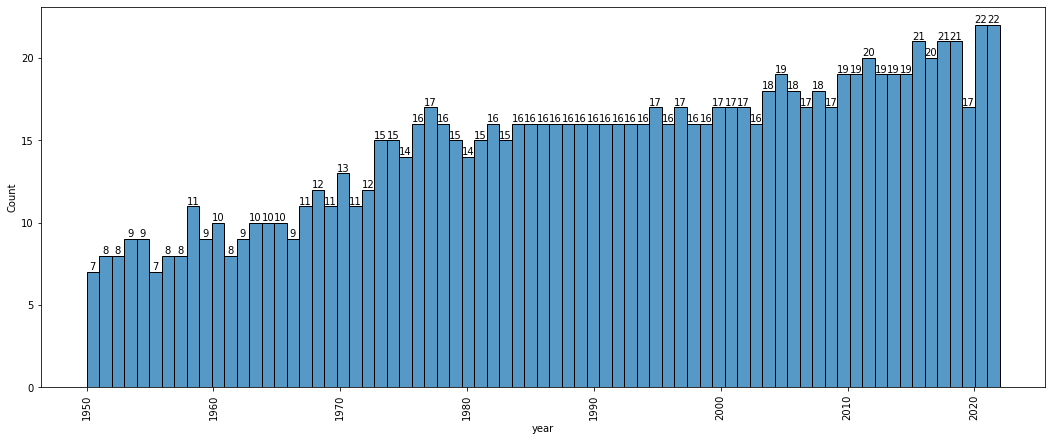

In [13]:
# histrogram of how many races occurred in a year
plt.figure(figsize=(18,7))
ax=sns.histplot(races, x = 'year', bins=races['year'].nunique())
plt.xticks(rotation='90')

for i in ax.containers:
    ax.bar_label(i,);

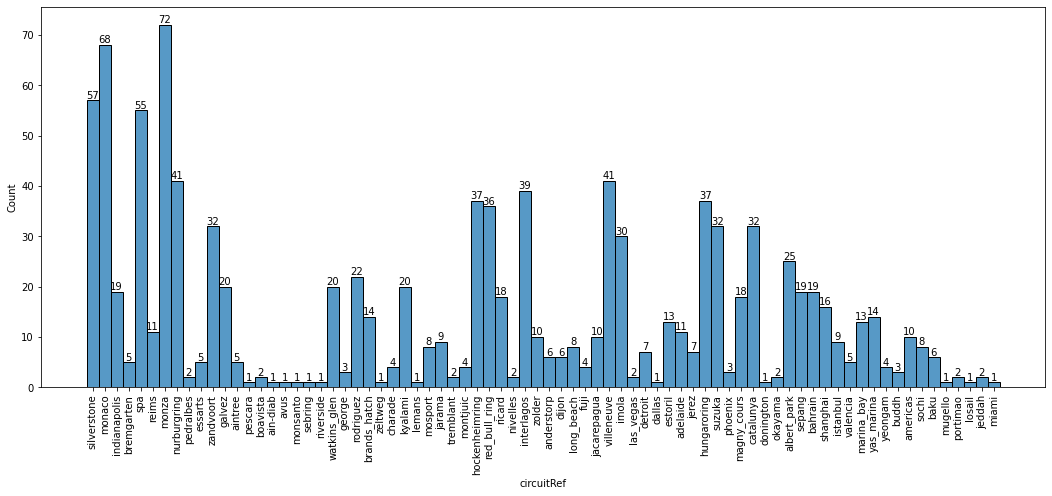

In [14]:
# histrogram of how many times did F1 race in that circuit
plt.figure(figsize=(18,7))
ax=sns.histplot(races, x = 'circuitRef', bins=races['circuitRef'].nunique())
plt.xticks(rotation='90')

for i in ax.containers:
    ax.bar_label(i,)

### results

In [15]:
results.head()
    # per year, per round, results of the races per driver/constructor/circuit/points/status

,year,round,circuitRef,constructorRef,driverRef,dob,nationality,grid,positionOrder,points,...,lat,lng,alt,country,resultId,raceId,circuitId,constructorId,driverId,statusId
0,1950,1,silverstone,alfa,farina,1906-10-30,Italian,1,1,9.0,...,52.0786,-1.01694,153,UK,20025,833,NaN,51,642,1
1,1950,1,silverstone,alfa,fagioli,1898-06-09,Italian,2,2,6.0,...,52.0786,-1.01694,153,UK,20026,833,NaN,51,786,1
2,1950,1,silverstone,alfa,reg_parnell,1911-07-02,British,4,3,4.0,...,52.0786,-1.01694,153,UK,20027,833,NaN,51,686,1
3,1950,1,silverstone,lago,cabantous,1904-10-08,French,6,4,3.0,...,52.0786,-1.01694,153,UK,20028,833,NaN,154,704,12
4,1950,1,silverstone,lago,rosier,1905-11-05,French,9,5,2.0,...,52.0786,-1.01694,153,UK,20029,833,NaN,154,627,12


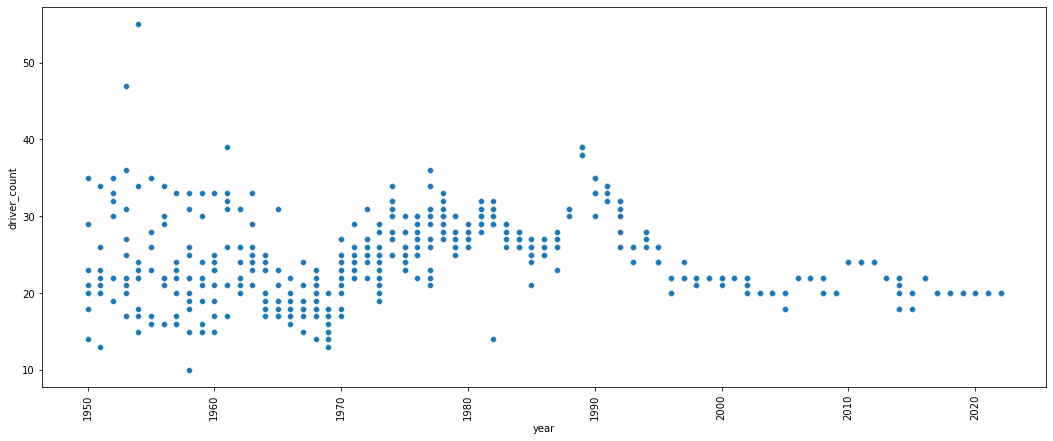

In [16]:
#groupby
results_drivercnt = pd.DataFrame(results.groupby(['year'])['round'].value_counts()).rename(columns = {'round': 'driver_count'})
results_drivercnt = results_drivercnt.reset_index()
results_drivercnt

# histrogram of how many drivers were in the grid every year
plt.figure(figsize=(18,7))
ax = sns.scatterplot(data = results_drivercnt, x = 'year', y = 'driver_count')
plt.xticks(rotation='90');

# # annotation
# xs = results_drivercnt['year']
# ys = results_drivercnt['driver_count']

# for x,y in zip(xs,ys):
#     label = y
#     plt.annotate(label, # this is the text
#                  (x,y), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center')

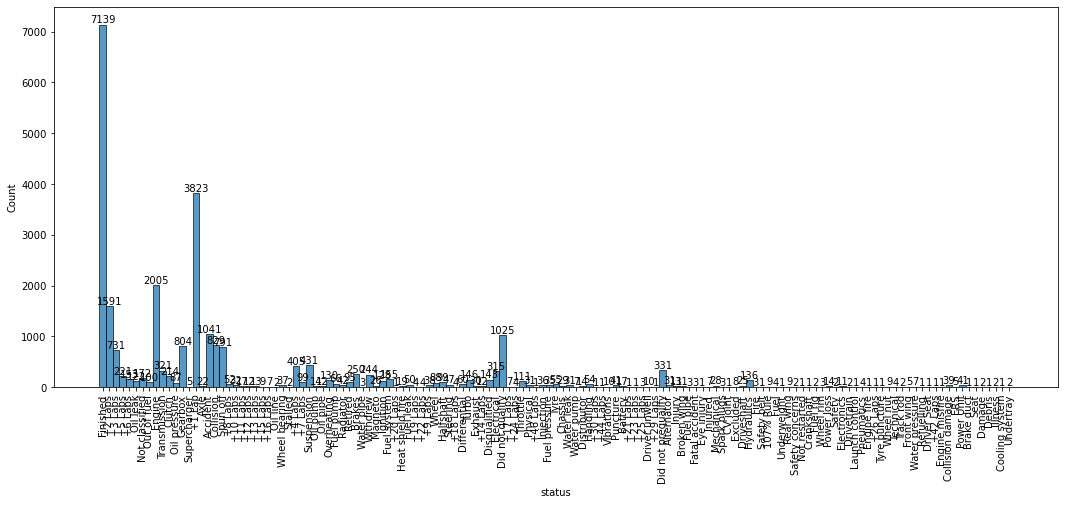

In [17]:
# histrogram of how status finishes (can further be broken down into decades to see if issues are recurring or changing through time)
plt.figure(figsize=(18,7))
ax = sns.histplot(data = results, x = 'status', bins=races['circuitRef'].nunique()+50)
plt.xticks(rotation='90')

for i in ax.containers:
    ax.bar_label(i,)

### qualifying

In [18]:
qualifying.head()
    # per year, per round, results of qualifying driver/constructor/circuit
    # data only begins from 1994

,year,round,circuitRef,constructorRef,driverRef,q,position,raceId,driverId,constructorId
0,1994,1,interlagos,williams,senna,01:16.0,1,257,102,3
1,1994,1,interlagos,benetton,michael_schumacher,01:16.3,2,257,30,22
2,1994,1,interlagos,ferrari,alesi,01:17.4,3,257,55,6
3,1994,1,interlagos,williams,damon_hill,01:17.6,4,257,71,3
4,1994,1,interlagos,sauber,frentzen,01:17.8,5,257,49,15


/var/folders/w5/7h1pv145523djq7r2_zpl8ph0000gn/T/ipykernel_69952/3865419369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualifying_timediff['q'] = pd.to_datetime(qualifying_timediff['q']) # convert quali time from object to datetime


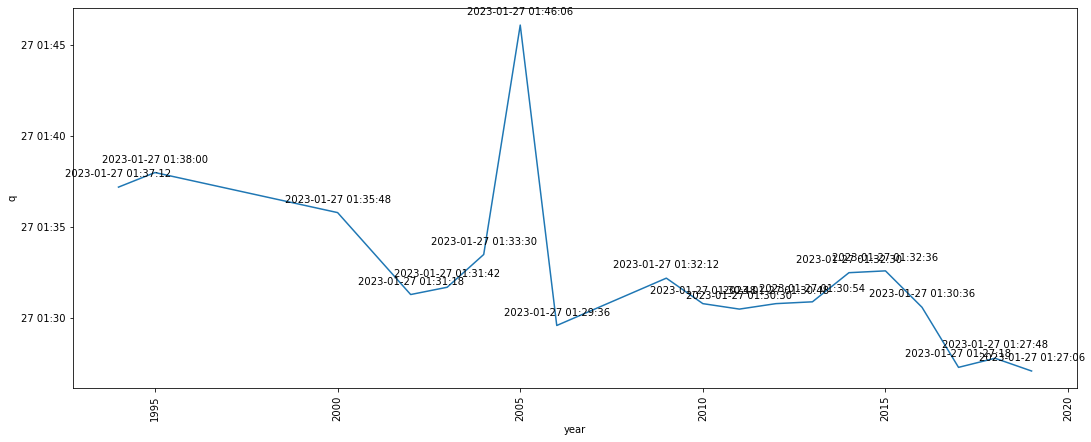

In [19]:
# mask one circuit only based on fastest qualifying in a year per circuit (monaco, interlagos, silverstone, suzuka)
qualifying_timediff = qualifying[(qualifying['circuitRef'] == 'suzuka') & (qualifying['position'] == 1)]
qualifying_timediff['q'] = pd.to_datetime(qualifying_timediff['q']) # convert quali time from object to datetime

# lineplot of the recorded qualifying lap time (pole position) through time
plt.figure(figsize=(18,7))
ax = sns.lineplot(data = qualifying_timediff, x = 'year', y = 'q', sort=False)
plt.xticks(rotation='90')

# annotation
xs = qualifying_timediff['year']
ys = qualifying_timediff['q']

for x,y in zip(xs,ys):
    label = y
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    
    # forecast on Tableau might be interesting

In [20]:
# qualifying_timediff for csv
qualifying_timediffcsv = qualifying[(qualifying['position'] == 1)]
qualifying_timediffcsv.to_csv('qualifying_timediff.csv')

### driver_standings

In [21]:
driver_standings.head()
    # per year, per round, race win results driver/constructor/circuit
    # wins and points are cumulative

,year,round,circuitRef,driverRef,position,wins,points,raceId,driverId
0,1950,1,silverstone,farina,1,1,9.0,833,642
1,1950,1,silverstone,fagioli,2,0,6.0,833,786
2,1950,1,silverstone,reg_parnell,3,0,4.0,833,686
3,1950,1,silverstone,cabantous,4,0,3.0,833,704
4,1950,1,silverstone,rosier,5,0,2.0,833,627


In [22]:
# Table of driver champions through the years
driver_standings_grp = pd.DataFrame(driver_standings.groupby(['year', 'driverRef'])['points'].max()).reset_index()
driver_standings_grp['ranking'] = driver_standings_grp.groupby(['year'])['points'].rank(ascending = False)
driver_standings_best = driver_standings_grp[driver_standings_grp['ranking'] == 1]
driver_standings_best.to_csv('driver_standings_best.csv')
driver_standings_best.head()

,year,driverRef,points,ranking
24,1950,farina,30.0,1.0
102,1951,fangio,31.0,1.0
168,1952,ascari,36.0,1.0
274,1953,ascari,34.5,1.0
403,1954,fangio,42.0,1.0


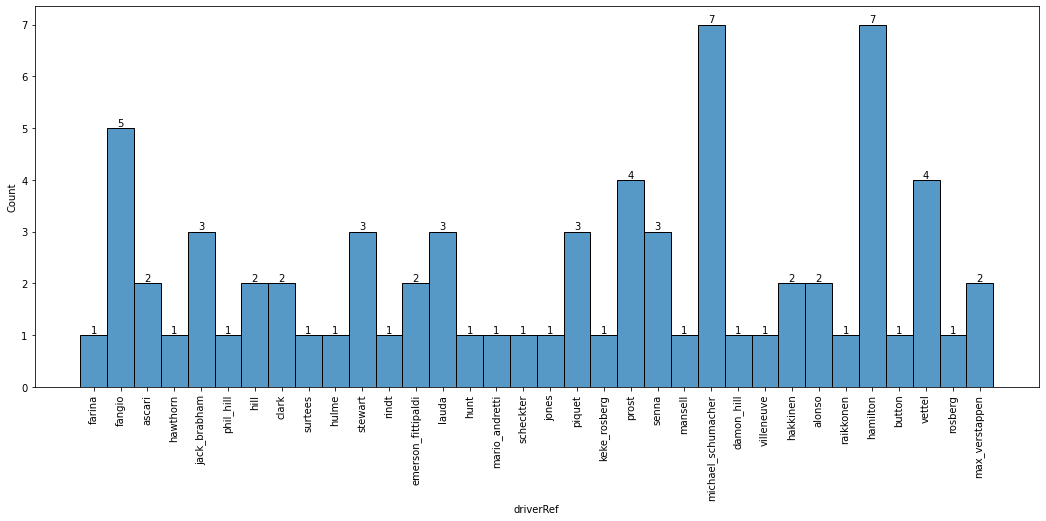

In [23]:
# histogram of driver championship wins
plt.figure(figsize=(18,7))
ax = sns.histplot(data = driver_standings_best, x = 'driverRef')
plt.xticks(rotation='90')

# annotation
for i in ax.containers:
    ax.bar_label(i,)

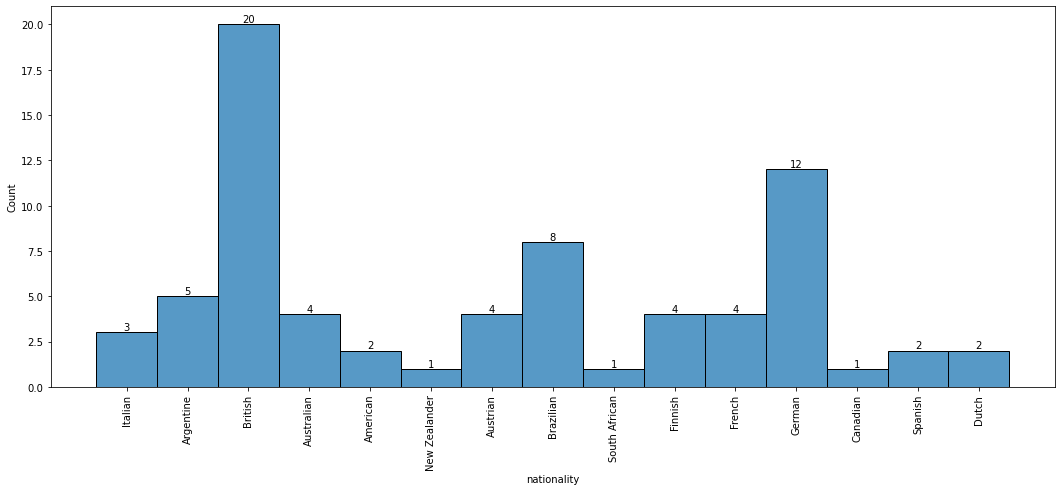

In [24]:
# table of driver champions and its nationality (German = 12 --> number of times a German won the championship)
driver_standings_best_nationality = pd.merge(driver_standings_best, df_drivers[['driverRef','nationality']],
                                            how = 'left',
                                            on = 'driverRef')

# histogram of driver championship wins by nationality
plt.figure(figsize=(18,7))
ax = sns.histplot(data = driver_standings_best_nationality, x = 'nationality')
plt.xticks(rotation='90')

# annotation
for i in ax.containers:
    ax.bar_label(i,)

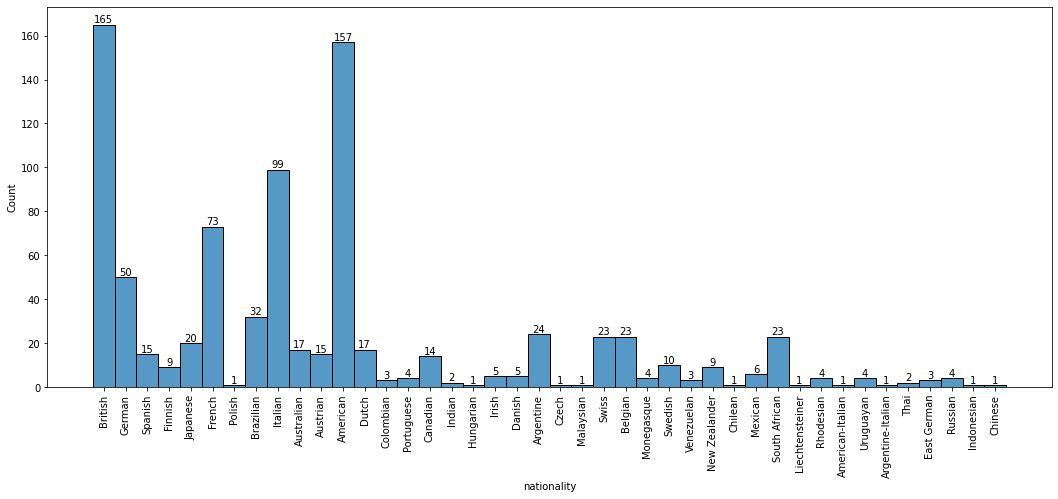

In [25]:
# cross check: histogram of driver nationality
plt.figure(figsize=(18,7))
ax = sns.histplot(data = df_drivers, x = 'nationality')
plt.xticks(rotation='90')

# annotation
for i in ax.containers:
    ax.bar_label(i,)

### constructor_standings

In [26]:
constructor_standings.head()
    # per year, per round, race win results constructor/circuit
    # wins and points are cumulative
    # dataset only begins from 1958

,year,round,circuitRef,constructorRef,position,wins,points,raceId,constructorId
0,1958,1,galvez,cooper,1,1,8.0,765,87
1,1958,1,galvez,ferrari,2,0,6.0,765,6
2,1958,1,galvez,maserati,3,0,3.0,765,105
3,1958,2,monaco,cooper,1,2,16.0,766,87
4,1958,2,monaco,ferrari,2,0,12.0,766,6


In [27]:
# Table of constructor champions through the years
constructor_standings_grp = pd.DataFrame(constructor_standings.groupby(['year','constructorRef'])['points'].max()).reset_index()
constructor_standings_grp['ranking'] = constructor_standings_grp.groupby(['year'])['points'].rank(ascending = False)
constructor_standings_best = constructor_standings_grp[constructor_standings_grp['ranking'] == 1]
constructor_standings_best.to_csv('constructor_standings_best.csv')
constructor_standings_best.head()

,year,constructorRef,points,ranking
8,1958,vanwall,48.0,1.0
13,1959,cooper-climax,40.0,1.0
29,1960,cooper-climax,48.0,1.0
44,1961,ferrari,45.0,1.0
52,1962,brm,42.0,1.0


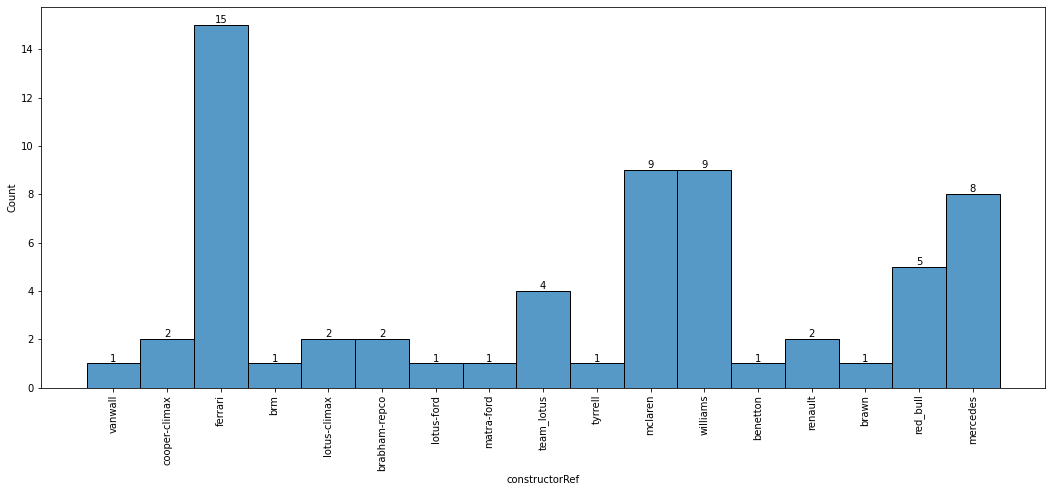

In [28]:
# histogram of constructor championship wins
plt.figure(figsize=(18,7))
ax = sns.histplot(data = constructor_standings_best, x = 'constructorRef')
plt.xticks(rotation='90')

# annotation
for i in ax.containers:
    ax.bar_label(i,)

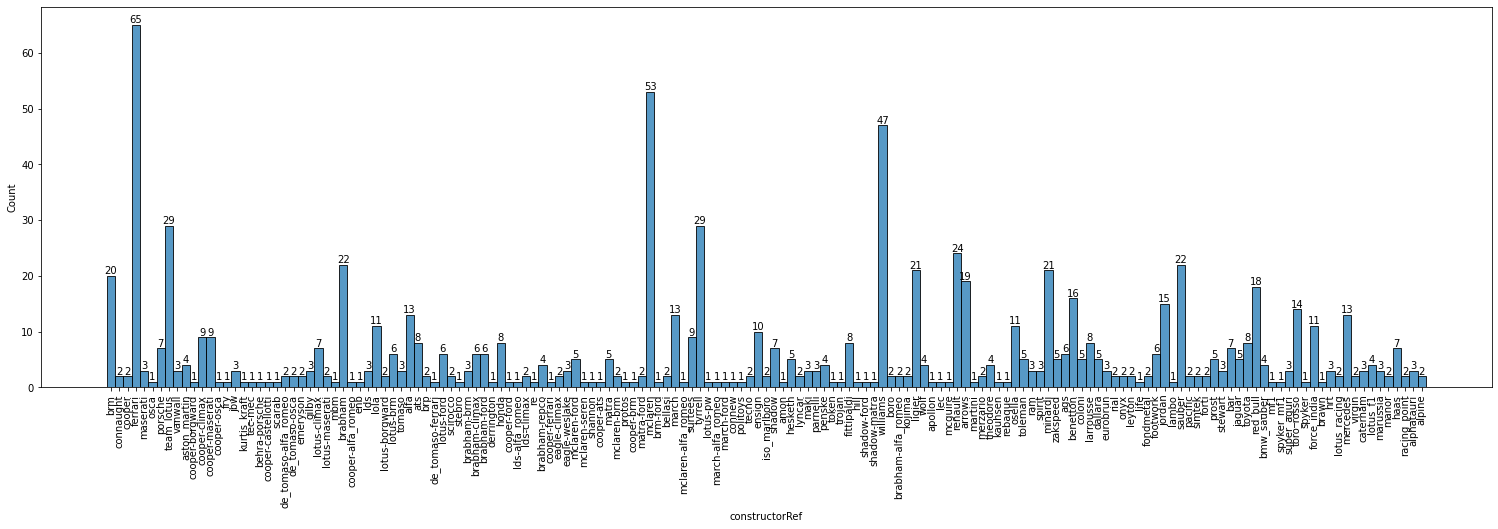

In [29]:
# histogram of how long a constructor has been participating in F1 (note: other teams may have rebranded i.e. Renault to Alpine)
plt.figure(figsize=(26,7))
ax = sns.histplot(data = constructor_standings_grp, x = 'constructorRef')
plt.xticks(rotation='90')

# annotation
for i in ax.containers:
    ax.bar_label(i,)

## MODELING DATAFRAME

In [30]:
# temporarily rename 
subset = results.copy()

# merge additional columns on constructors, drivers and qualifying
    # add: conspoints, conswins, consposition
merge_subset = pd.merge(subset, 
                            constructor_standings[['raceId', 'constructorId', 'position', 'wins', 'points']],
                   how='left', 
                   on=['raceId', 'constructorId'])

merge_subset.rename(columns = {'points_x': 'race_pts',
                        'position': 'cnstr_pos',
                        'wins': 'cnstr_wins',
                        'points_y': 'cnstr_pts'}, inplace = True)

    # add: driverpoints, driverwins, driverposition
merge_subset2 = pd.merge(merge_subset, 
                        driver_standings[['raceId', 'driverId', 'position', 'wins', 'points']],
               how='left', 
               on=['raceId', 'driverId'])  

merge_subset2.rename(columns = {'position': 'driver_pos',
                        'wins': 'driver_wins',
                        'points': 'driver_pts'}, inplace = True)    


# convert dobb, q to datetime
merge_subset2['dob'] = pd.to_datetime(merge_subset2['dob'])


    # extract year feature
merge_subset2['dob_year'] = merge_subset2['dob'].dt.year

    # calculate age of driver vis-a-vis race year
merge_subset2['age'] = merge_subset2.year - merge_subset2.dob_year


# drop unnecessary columns
subset = merge_subset2.drop(columns = ['laps', 'time', 'resultId', 'circuitId', 'constructorId', 
                                'driverId', 'statusId', 'dob', 'dob_year', 'milliseconds'])
subset.rename(columns = {'points_x': 'driver_pts',
                        'position': 'cnstr_pos',
                        'wins': 'cnstr_wins',
                        'points_y': 'cnstr_pts'}, inplace = True)
subset.sort_values(by = ['year', 'round', 'positionOrder'], ascending = True, inplace = True)
subset.reset_index(drop = True, inplace = True)
subset

,year,round,circuitRef,constructorRef,driverRef,nationality,grid,positionOrder,race_pts,status,...,alt,country,raceId,cnstr_pos,cnstr_wins,cnstr_pts,driver_pos,driver_wins,driver_pts,age
0,1950,1,silverstone,alfa,farina,Italian,1,1,9.0,Finished,...,153,UK,833,NaN,NaN,NaN,1.0,1.0,9.0,44
1,1950,1,silverstone,alfa,fagioli,Italian,2,2,6.0,Finished,...,153,UK,833,NaN,NaN,NaN,2.0,0.0,6.0,52
2,1950,1,silverstone,alfa,reg_parnell,British,4,3,4.0,Finished,...,153,UK,833,NaN,NaN,NaN,3.0,0.0,4.0,39
3,1950,1,silverstone,lago,cabantous,French,6,4,3.0,+2 Laps,...,153,UK,833,NaN,NaN,NaN,4.0,0.0,3.0,46
4,1950,1,silverstone,lago,rosier,French,9,5,2.0,+2 Laps,...,153,UK,833,NaN,NaN,NaN,5.0,0.0,2.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26029,2022,22,yas_marina,williams,latifi,Canadian,20,16,0.0,Finished,...,3,UAE,1096,NaN,NaN,NaN,NaN,NaN,NaN,27
26030,2022,22,yas_marina,alphatauri,tsunoda,Japanese,11,17,0.0,Finished,...,3,UAE,1096,NaN,NaN,NaN,NaN,NaN,NaN,22
26031,2022,22,yas_marina,mclaren,norris,British,7,18,6.0,Finished,...,3,UAE,1096,NaN,NaN,NaN,NaN,NaN,NaN,23
26032,2022,22,yas_marina,haas,kevin_magnussen,Danish,16,19,0.0,Finished,...,3,UAE,1096,NaN,NaN,NaN,NaN,NaN,NaN,30


## DATA IMPUTATION

In [31]:
# data imputation method 3
subset.loc[subset.loc[:,'cnstr_pos'].isnull(),'cnstr_pos']=subset.loc[:,'cnstr_pos'].mean()
subset.loc[subset.loc[:,'cnstr_wins'].isnull(),'cnstr_wins']=subset.loc[:,'cnstr_wins'].mean()
subset.loc[subset.loc[:,'cnstr_pts'].isnull(),'cnstr_pts']=subset.loc[:,'cnstr_pts'].mean()
subset

,year,round,circuitRef,constructorRef,driverRef,nationality,grid,positionOrder,race_pts,status,...,alt,country,raceId,cnstr_pos,cnstr_wins,cnstr_pts,driver_pos,driver_wins,driver_pts,age
0,1950,1,silverstone,alfa,farina,Italian,1,1,9.0,Finished,...,153,UK,833,6.49349,0.77627,36.095275,1.0,1.0,9.0,44
1,1950,1,silverstone,alfa,fagioli,Italian,2,2,6.0,Finished,...,153,UK,833,6.49349,0.77627,36.095275,2.0,0.0,6.0,52
2,1950,1,silverstone,alfa,reg_parnell,British,4,3,4.0,Finished,...,153,UK,833,6.49349,0.77627,36.095275,3.0,0.0,4.0,39
3,1950,1,silverstone,lago,cabantous,French,6,4,3.0,+2 Laps,...,153,UK,833,6.49349,0.77627,36.095275,4.0,0.0,3.0,46
4,1950,1,silverstone,lago,rosier,French,9,5,2.0,+2 Laps,...,153,UK,833,6.49349,0.77627,36.095275,5.0,0.0,2.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26029,2022,22,yas_marina,williams,latifi,Canadian,20,16,0.0,Finished,...,3,UAE,1096,6.49349,0.77627,36.095275,NaN,NaN,NaN,27
26030,2022,22,yas_marina,alphatauri,tsunoda,Japanese,11,17,0.0,Finished,...,3,UAE,1096,6.49349,0.77627,36.095275,NaN,NaN,NaN,22
26031,2022,22,yas_marina,mclaren,norris,British,7,18,6.0,Finished,...,3,UAE,1096,6.49349,0.77627,36.095275,NaN,NaN,NaN,23
26032,2022,22,yas_marina,haas,kevin_magnussen,Danish,16,19,0.0,Finished,...,3,UAE,1096,6.49349,0.77627,36.095275,NaN,NaN,NaN,30


---
# <font color='yellow'>Analysis</font>

In [32]:
subset.to_csv('df_tableau.csv')
subset.head()

,year,round,circuitRef,constructorRef,driverRef,nationality,grid,positionOrder,race_pts,status,...,alt,country,raceId,cnstr_pos,cnstr_wins,cnstr_pts,driver_pos,driver_wins,driver_pts,age
0,1950,1,silverstone,alfa,farina,Italian,1,1,9.0,Finished,...,153,UK,833,6.49349,0.77627,36.095275,1.0,1.0,9.0,44
1,1950,1,silverstone,alfa,fagioli,Italian,2,2,6.0,Finished,...,153,UK,833,6.49349,0.77627,36.095275,2.0,0.0,6.0,52
2,1950,1,silverstone,alfa,reg_parnell,British,4,3,4.0,Finished,...,153,UK,833,6.49349,0.77627,36.095275,3.0,0.0,4.0,39
3,1950,1,silverstone,lago,cabantous,French,6,4,3.0,+2 Laps,...,153,UK,833,6.49349,0.77627,36.095275,4.0,0.0,3.0,46
4,1950,1,silverstone,lago,rosier,French,9,5,2.0,+2 Laps,...,153,UK,833,6.49349,0.77627,36.095275,5.0,0.0,2.0,45


### <font color='yellow'>History</font>
- Grand Prix locations size (count) ('df_tableau.csv')
    - in the 50s, races were only in Euorpe
    - they started expanding in the Americas in early 70s
    - further expanded in East Asia in 90s and also in Middle East
    - some of the most famous - monza, monaco, silverstone, spa
    
- GOAT driver champ ('driver_standings_best.csv')

- GOAT constructor champ ('constructor_standings_best.csv')

- Lap time evolution('qualifying_timediff.csv')
    - based on fastest qualifying time
    - based on famous and long-running circuits
    - other than Silverstone, seems like everything is downward trending

### Impact on wins

#### <font color='yellow'>AGE: What is the impact of age on winning a race?</font>
('df_tableau.csv')
- data from 1950
- there is a downward trend on age and winning; winners nowadays are younger than in the past
- but also, the average age in the 50s was close to 40, while today, it's below 30

#### <font color='yellow'>HOME COURT ADVANTAGE: What is the impact of nationality on winning a race at home?</font>
('nationality_win.csv'), ('nationality_country_win.csv')
- British, German and Brazilians are the top 3 nationalities with the most wins
- Though looking at the total number of races that ALL British drivers joined, the Argentines, Germans, British are the effective
- Though Argentines only raced 395 times, they won 40 Grand Prix
    - majority were drivers in the first 2 decades
    
- overall, it seems like with the major nationality competitors (xxx), it indeed has some pyschological effect to perhaps win in their home race
    - (out of the total races done in a certain circuit, how many times did a certain nationality win in it)

> #### count of winners by nationality (percent of total)

In [33]:
# nationality count: number of times a "British" driver raced
nationality_count = pd.DataFrame(subset['nationality'].value_counts()).reset_index().rename(columns = {'index': 'nationality', 'nationality': 'natio_count'})
nationality_count['per_totalnatio'] = round(nationality_count['natio_count'] / nationality_count['natio_count'].sum(),2)
nationality_count.head()

,nationality,natio_count,per_totalnatio
0,British,4450,0.17
1,Italian,3452,0.13
2,French,3024,0.12
3,German,2386,0.09
4,Brazilian,1955,0.08


In [34]:
# count of winners by nationality
subset_win = subset[subset['positionOrder'] == 1]
subset_win = subset_win[['year', 'circuitRef', 'nationality','positionOrder']].reset_index(drop = True)

natio_win = pd.DataFrame(subset_win['nationality'].value_counts()).reset_index().rename(columns = {'index': 'nationality', 'nationality': 'win_count'})
natio_win.head()

,nationality,win_count
0,British,312
1,German,179
2,Brazilian,101
3,French,81
4,Finnish,57


In [35]:
# percentage of winners by country vis-a-vis the total number of drivers(with same nationality)
    # nationality: merged with total nationatlity count on wins and nationality count number of times a driver of that certain nationality ever raced
    # per_totalnatio: percentage of certain driver's nationality over total number of drivers
    # per_natio_win: ratio of wins vs total driver 
nationality_win = pd.merge(natio_win, nationality_count,
                           how = 'left',
                           on = 'nationality')
nationality_win['per_natio_win'] = round(nationality_win['win_count'] / (nationality_win['natio_count'] - nationality_win['win_count']),2)
nationality_win.sort_values(by = 'per_natio_win', ascending = False, inplace = True)
nationality_win.to_csv('nationality_win.csv')
nationality_win.head()

,nationality,win_count,natio_count,per_totalnatio,per_natio_win
8,Argentine,40,395,0.02,0.11
0,British,312,4450,0.17,0.08
9,Dutch,35,481,0.02,0.08
1,German,179,2386,0.09,0.08
6,Australian,43,823,0.03,0.06


> #### nationality-country win ratio

In [36]:
# circuits and country (country is written as nationality to match the nationality column)
dictionary = {'circuitRef': 
              ['silverstone', 'monaco', 'indianapolis', 'bremgarten', 'spa',
       'reims', 'monza', 'nurburgring', 'pedralbes', 'essarts',
       'zandvoort', 'galvez', 'aintree', 'pescara', 'boavista',
       'ain-diab', 'avus', 'monsanto', 'sebring', 'riverside',
       'watkins_glen', 'george', 'rodriguez', 'brands_hatch', 'zeltweg',
       'charade', 'kyalami', 'lemans', 'mosport', 'jarama', 'tremblant',
       'montjuic', 'hockenheimring', 'red_bull_ring', 'ricard',
       'nivelles', 'interlagos', 'zolder', 'anderstorp', 'dijon',
       'long_beach', 'fuji', 'jacarepagua', 'villeneuve', 'imola',
       'las_vegas', 'detroit', 'dallas', 'estoril', 'adelaide', 'jerez',
       'hungaroring', 'suzuka', 'phoenix', 'magny_cours', 'catalunya',
       'donington', 'okayama', 'albert_park', 'sepang', 'bahrain',
       'shanghai', 'istanbul', 'valencia', 'marina_bay', 'yas_marina',
       'yeongam', 'buddh', 'americas', 'sochi', 'baku', 'mugello',
       'portimao', 'losail', 'jeddah', 'miami'],
              'circuitNatio':
              ['British', 'Monegasque', 'American', 'Swiss', 'Belgian',
       'French', 'Italian', 'German', 'Spanish', 'French',
       'Dutch', 'Argentine', 'British', 'Italian', 'Portuguese',
       'Moroccan', 'German', 'Portuguese', 'American', 'American',
       'American', 'South African', 'Mexican', 'British', 'Austrian',
       'French', 'South African', 'French', 'Canadian', 'Spanish', 'Canadian',
       'Spanish', 'German', 'Austrian', 'French',
       'Belgian', 'Brazilian', 'Belgian', 'Swedish', 'French',
       'American', 'Japanese', 'Brazilian', 'Canadian', 'Italian',
       'American', 'American', 'American', 'Portuguese', 'Australian', 'Spanish',
       'Hungarian', 'Japanese', 'American', 'French', 'Spanish',
       'British', 'Japanese', 'Australian', 'Malaysian', 'Bahraini',
       'Chinese', 'Turkish', 'Spanish', 'Singaporean', 'Emirati',
       'Korean', 'Indian', 'American', 'Russian', 'Azerbaijani', 'Italian',
       'Portuguese', 'Qatari', 'Saudi Arabian', 'American']
             }
circuit_country = pd.DataFrame(dictionary)
circuit_country.head()

,circuitRef,circuitNatio
0,silverstone,British
1,monaco,Monegasque
2,indianapolis,American
3,bremgarten,Swiss
4,spa,Belgian


In [37]:
# merge winners by nationality and circuit country
nationality_country_win = pd.merge(subset_win, circuit_country,
                          how = 'left',
                          on = 'circuitRef')

# further filter circuits to only those where there is a home driver
nationality_country_win = nationality_country_win[nationality_country_win['circuitNatio'].isin(nationality_country_win['nationality'].unique())]
nationality_country_win.to_csv('nationality_country_win.csv')
nationality_country_win.head()

,year,circuitRef,nationality,positionOrder,circuitNatio
0,1950,silverstone,Italian,1,British
1,1950,monaco,Argentine,1,Monegasque
2,1950,indianapolis,American,1,American
3,1950,bremgarten,Italian,1,Swiss
4,1950,spa,Argentine,1,Belgian


#### <font color='yellow'>GRID POSITION: What is the impact of your qualifying result on winning a race?</font>
('corr_table.csv')
- NOTE: run the notebook chronologically to get the correct result as the tables/variables are named similarly except the final csv file
- data from 1950
- built a correlation table between pole position and P1 win
- filtered in Tableau the circuits where there were less than 10 races (unfamous circuits get ruled out)
- 65-70% is my high correlation metric
- tracks where it is known to be difficult to overtake give importance to pole position
- extra table ('corr_table_now.csv')
    

> #### correlation matrix from 1950

In [38]:
# filtering only from the "relevant" year 1950 onwards, applying dummy variables
grid_subset = subset[(subset['grid'] == 1) & (subset['year'] >= 1950)][['year','circuitRef','grid', 'positionOrder']]
grid_subset['dummy'] = grid_subset['positionOrder'].apply(lambda x: 1 if x==1 else 0)
grid_subset.head()

,year,circuitRef,grid,positionOrder,dummy
0,1950,silverstone,1,1,1
23,1950,monaco,1,1,1
52,1950,indianapolis,1,7,0
92,1950,bremgarten,1,12,0
102,1950,spa,1,4,0


In [39]:
# obtain correlation matrices of grid-positionOrder by circuitRef
corr_container = []
grid_container = []
for circuit in grid_subset['circuitRef']:
    corr_loop = grid_subset[grid_subset['circuitRef'] == circuit]
    grid_container.append(circuit)
    corr_container.append(corr_loop.corr())  

In [40]:
# get the chornological list of grids ran by the loop and combine it with the result of the correlation matrix
pd.Series(grid_container) 

0        silverstone
1             monaco
2       indianapolis
3         bremgarten
4                spa
            ...     
1107          suzuka
1108        americas
1109       rodriguez
1110      interlagos
1111      yas_marina
Length: 1112, dtype: object

In [41]:
# concat matrices, keep only relevant figures and combine it with the circuitRef series
corr_table = pd.concat(corr_container)
corr_table = corr_table[corr_table.index.isin(['dummy'])] # filter only the necessary figures
corr_table = corr_table.drop(columns = 'dummy')
corr_table = (abs(corr_table['positionOrder']).round(2)).to_frame()
corr_table['circuitRef'] = grid_container
corr_table.reset_index(drop = True)
corr_table.to_csv('corr_table.csv')
corr_table.head()

,positionOrder,circuitRef
dummy,0.56,silverstone
dummy,0.66,monaco
dummy,0.44,indianapolis
dummy,0.39,bremgarten
dummy,0.59,spa


> #### correlation matrix from 2000

In [42]:
# filtering only from the "relevant" year 2000 onwards, applying dummy variables
grid_subset = subset[(subset['grid'] == 1) & (subset['year'] >= 2000)][['year','circuitRef','grid', 'positionOrder']]
grid_subset['dummy'] = grid_subset['positionOrder'].apply(lambda x: 1 if x==1 else 0)
grid_subset.head()

,year,circuitRef,grid,positionOrder,dummy
16890,2000,albert_park,1,17,0
16909,2000,interlagos,1,14,0
16919,2000,imola,1,2,0
16959,2000,silverstone,1,20,0
16966,2000,catalunya,1,5,0


In [43]:
# obtain correlation matrices of grid-positionOrder by circuitRef
corr_container = []
grid_container = []
for circuit in grid_subset['circuitRef']:
    corr_loop = grid_subset[grid_subset['circuitRef'] == circuit]
    grid_container.append(circuit)
    corr_container.append(corr_loop.corr())  

In [44]:
# get the chornological list of grids ran by the loop and combine it with the result of the correlation matrix
pd.Series(grid_container) 

0      albert_park
1       interlagos
2            imola
3      silverstone
4        catalunya
          ...     
428         suzuka
429       americas
430      rodriguez
431     interlagos
432     yas_marina
Length: 433, dtype: object

In [45]:
# concat matrices, keep only relevant figures and combine it with the circuitRef series
corr_table_now = pd.concat(corr_container)
corr_table_now = corr_table_now[corr_table_now.index.isin(['dummy'])] # filter only the necessary figures
corr_table_now = corr_table_now.drop(columns = 'dummy')
corr_table_now = (abs(corr_table_now['positionOrder']).round(2)).to_frame()
corr_table_now['circuitRef'] = grid_container
corr_table_now.reset_index(drop = True)
corr_table_now.to_csv('corr_table_now.csv')
corr_table_now.head()

,positionOrder,circuitRef
dummy,0.56,albert_park
dummy,0.54,interlagos
dummy,0.37,imola
dummy,0.41,silverstone
dummy,0.69,catalunya


#### <font color='yellow'>CIRUIT: What is the impact of circuits on winning a race (for a team)?</font>
('power_down.csv')
- NOTE: data is only from 2014 to find equal footing; 2014-2021, the year all engines are the same
- Out of the number of times that these big 4 teams have raced in a power and high downforce track, there is no clear significance if they perform better or worse.
- But it is clear that over the last 7-10 years, Mercedes has been dominating

- Sochi is a prime example of a Mercedes track: the Silver Arrows have won there every year since F1 began racing at the Russian coastal city in 2014, having emerged from qualifying in pole position in five out of seven attempts.

- A Red Bull track is a little harder to define, given that the team has only won more than three races in a single season once (in 2018) since Sebastian Vettel secured his fourth world title with the outfit in 2013. And even in that 2018 season, it only won four.

>#### percentage & count

In [46]:
# filtering only power tracks
power_track = subset[(subset['constructorRef'].isin(['ferrari','red_bull','mercedes','mclaren'])) & 
                     (subset['year'].isin([2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])) & (subset['positionOrder'] == 1) & 
                     (subset['circuitRef'].isin(['bahrain', 'baku', 'monza', 'shanghai', 'spa', 'villneuve', 'zandvoort']))]
power_track = power_track['constructorRef'].value_counts()/power_track['year'].value_counts().sum()
power_track

mercedes    0.358209
ferrari     0.283582
red_bull    0.194030
mclaren     0.164179
Name: constructorRef, dtype: float64

In [47]:
# filtering only high downforce tracks
downforce_track = subset[(subset['constructorRef'].isin(['ferrari','red_bull','mercedes','mclaren'])) & (subset['year'].isin([2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])) & (subset['positionOrder'] == 1) & 
                         (subset['circuitRef'].isin(['albert_park','catalunya', 'hungaroring', 'interlagos', 'marina_bay', 
                                                     'miami', 'monaco', 'portimao', 'ricard', 'rodriguez', 'silverstone']))]
downforce_track = downforce_track['constructorRef'].value_counts()/downforce_track['year'].value_counts().sum()
downforce_track

mercedes    0.398230
red_bull    0.238938
ferrari     0.203540
mclaren     0.159292
Name: constructorRef, dtype: float64

In [48]:
# filtering only power tracks, count
power_track_count = subset[(subset['constructorRef'].isin(['ferrari','red_bull','mercedes','mclaren'])) & 
                     (subset['year'].isin([2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])) & (subset['positionOrder'] == 1) & 
                     (subset['circuitRef'].isin(['bahrain', 'baku', 'monza', 'shanghai', 'spa', 'villneuve', 'zandvoort']))]
power_track_count = power_track_count['constructorRef'].value_counts()
power_track_count

mercedes    24
ferrari     19
red_bull    13
mclaren     11
Name: constructorRef, dtype: int64

In [49]:
# filtering only high downforce tracks, count
downforce_track_count = subset[(subset['constructorRef'].isin(['ferrari','red_bull','mercedes','mclaren'])) & (subset['year'].isin([2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021])) & (subset['positionOrder'] == 1) & 
                         (subset['circuitRef'].isin(['albert_park','catalunya', 'hungaroring', 'interlagos', 'marina_bay', 
                                                     'miami', 'monaco', 'portimao', 'ricard', 'rodriguez', 'silverstone']))]
downforce_track_count = downforce_track_count['constructorRef'].value_counts()
downforce_track_count

mercedes    45
red_bull    27
ferrari     23
mclaren     18
Name: constructorRef, dtype: int64

In [50]:
pd.array(power_track), pd.array(downforce_track), pd.array(power_track_count), pd.array(downforce_track_count)

(<PandasArray>
 [ 0.3582089552238806,  0.2835820895522388, 0.19402985074626866,
  0.16417910447761194]
 Length: 4, dtype: float64,
 <PandasArray>
 [0.39823008849557523, 0.23893805309734514, 0.20353982300884957,
   0.1592920353982301]
 Length: 4, dtype: float64,
 <PandasArray>
 [24, 19, 13, 11]
 Length: 4, dtype: int64,
 <PandasArray>
 [45, 27, 23, 18]
 Length: 4, dtype: int64)

In [51]:
power_down = {'constructorRef': ['mercedes', 'ferrari', 'red_bull', 'mclaren'], 
               'power':  [0.3582089552238806,  0.2835820895522388, 0.19402985074626866,
  0.16417910447761194], 
               'down': [0.39823008849557523, 0.20353982300884957, 0.23893805309734514,
   0.1592920353982301],
              'power_count': [24, 19, 13, 11],
              'down_count':  [45, 23, 27, 18]
             }
power_down = pd.DataFrame(power_down)
power_down.to_csv('power_down.csv')
power_down

,constructorRef,power,down,power_count,down_count
0,mercedes,0.358209,0.398230,24,45
1,ferrari,0.283582,0.203540,19,23
2,red_bull,0.194030,0.238938,13,27
3,mclaren,0.164179,0.159292,11,18


>#### Count

#### <font color='yellow'>MISHAP: What are the major reasons of drivers not finishing? Does it change over time? Are there circuits prone to failures/accidents?</font>
('mishap.csv'), ('accident_rate.csv'), ('accident_rate_peryear.csv')
- Mishaps:
    - Engine failure is the top reason accounting for 20%
    - Accidents and Collisions are the next reasons accounting for 18% in total
    - Other reasons are a lot more towards car issues than driver errors
- Diving into Accidents/Collisions:
    - shown here are the most dangerous circuits (accident count / # of drivers who have raced there)
    - filtered out those that have at less than 30 accidents
    - there is an x% chance that an accident might occur on the drivers
- Racing accidents through time:
    - Racing legend Sir Jackie Stewart has said that during the years that represented the peak of his career in the late 1960s and early 70s, anyone continuously racing had a two-out-of-three chance of dying.
    - In the 50s there wasn't a safety culture. It was just after the Second World War - people were used to the idea that people could die and I think that people found it almost acceptable
    - There just wasn't a safety culture. Even seatbelts were not made mandatory until 1972. 
    - 19 drivers have died in 1950-1980. Four decades after, there has only been 7 drivers had died since

> #### Reasons for mishap

In [52]:
# group by circuit, and status to count number of mishaps
mishap = pd.DataFrame(subset.groupby(['circuitRef'])['status'].value_counts()).rename(columns = {'status' : 'status_count'}).reset_index()
mishap.to_csv('mishap.csv')
mishap.head()

,circuitRef,status,status_count
0,adelaide,Finished,44
1,adelaide,+1 Lap,28
2,adelaide,Spun off,27
3,adelaide,Engine,25
4,adelaide,+2 Laps,20


> #### Most dangerous circuits

In [53]:
# accidents/collisions per year per circuit
subset_accident = subset[subset['status'].isin(['Accident', 'Collision'])]
accident_collision = pd.DataFrame(subset_accident.groupby(['year','circuitRef'])['status'].value_counts()).rename(columns = {'status' : 'status_count'}).reset_index()
accident_collision = pd.DataFrame(subset_accident.groupby(['year','circuitRef'])['status'].value_counts()).rename(columns = {'status' : 'status_count'}).reset_index()
accident_collision.head()

,year,circuitRef,status,status_count
0,1950,bremgarten,Accident,2
1,1950,monaco,Accident,10
2,1950,monaco,Collision,1
3,1951,bremgarten,Accident,3
4,1951,indianapolis,Accident,1


In [54]:
# sum up accidents and collisions grouped by circuitRef
accident_collision_total = pd.DataFrame(accident_collision.groupby('circuitRef')['status_count'].sum()).reset_index()
accident_collision_total.head()

,circuitRef,status_count
0,adelaide,31
1,ain-diab,5
2,aintree,4
3,albert_park,62
4,americas,7


In [55]:
# number of drivers who raced in that specific circuit
accident_collision_drivercount = pd.DataFrame(subset['circuitRef'].value_counts()).reset_index().rename(columns = {'circuitRef' : 'driver_count', 'index': 'circuitRef'})

In [56]:
# accident rate per circuit
accident_rate = pd.merge(accident_collision_total, accident_collision_drivercount,
                         how = 'left',
                         on = 'circuitRef')
accident_rate['per'] = round(accident_rate['status_count'] / accident_rate['driver_count'], 2)
accident_rate.sort_values(by = 'per', ascending = False, inplace = True)
accident_rate.to_csv('accident_rate.csv')
accident_rate.head()

,circuitRef,status_count,driver_count,per
45,mugello,6,20,0.30
1,ain-diab,5,25,0.20
36,long_beach,41,220,0.19
16,detroit,28,191,0.15
69,yeongam,13,94,0.14


> #### Accident rate through time

In [57]:
# total accidents/collisions per year
accident_collision_total_years = pd.DataFrame(accident_collision.groupby('year')['status_count'].sum()).reset_index()
accident_collision_total_years.head()

,year,status_count
0,1950,13
1,1951,9
2,1952,5
3,1953,20
4,1954,15


In [58]:
# total participants per year
accident_collision_drivercount_years = pd.DataFrame(subset['year'].value_counts()).reset_index().rename(columns = {'year': 'driver_count', 'index': 'year'}) #total participants per year
accident_collision_drivercount_years.head()

,year,driver_count
0,1989,620
1,1990,542
2,1991,539
3,1988,495
4,2012,480


In [59]:
# accident rate per year
accident_rate_peryear = pd.merge(accident_collision_total_years, accident_collision_drivercount_years,
                         how = 'left',
                         on = 'year')
accident_rate_peryear['per'] = round(accident_rate_peryear['status_count'] / accident_rate_peryear['driver_count'], 2)
accident_rate_peryear.sort_values(by = 'per', ascending = False, inplace = True)
accident_rate_peryear.to_csv('accident_rate_peryear.csv')
accident_rate_peryear.head()

,year,status_count,driver_count,per
25,1975,54,363,0.15
27,1977,63,477,0.13
26,1976,50,434,0.12
23,1973,38,357,0.11
58,2008,40,368,0.11
